# Ice sheet velocity data from satellite observations: temporal and spatial coverage and data completeness for trend analysis in glaciological applications

Production date: 31-05-2025

Dataset version: 1.3 to 1.5

Produced by: Yoni Verhaegen and Philippe Huybrechts (Vrije Universiteit Brussel)

## üåç Use case: Monitoring surface ice flow velocity patterns over Greenland to detect the ice sheet's dynamic response to climate change 

## ‚ùì Quality assessment question
* **"Is the dataset of sufficient spatial/temporal resolution, coverage and completeness to derive multi-year trends of horizontal surface flow velocities and the associated patterns of solid ice discharge?"**

Ice sheets are not static, but instead flow. The total velocity magnitude is the sum of the velocity related to internal ice deformation, and is complemented by basal sliding and bed deformation components. Mapping ice sheet surface flow velocities and their temporal changes provides key information for investigating the dynamic response of the ice sheets to climate change. Remote sensing techniques, such as the use of satellites, are an important feature to derive and study these flow velocities. Satellites are able to inspect directly and repeatedly large areas of ice, and, as such are able to detect the movement of its surface. Remote sensing techniques that use satellite data are therefore considered the only feasible manner to derive accurate surface velocities of the ice sheets on a regular basis. In this dataset, they are derived by applying offset tracking techniques using Sentinel-1 synthetic aperture radar (SAR) satellite data. The main principle of the "[Ice sheet velocity for Antarctica and Greenland derived from satellite observations](https://cds.climate.copernicus.eu/datasets/satellite-greenland-ice-sheet-velocity?tab=overview)" dataset therefore relies on the preservation of surface features or other detectable patterns (e.g. speckle) in between multiple image acquisition periods. The extraction of these features/patterns from images acquired over different time periods is used to detect their displacements, and with further processing this information can be used to derive velocity fields [[1](https://doi.org/10.3390/rs70709371)]. 

This notebook investigates how well the dataset on the CDS (here we use versions 1.3 to 1.5) can be used to derive mean values, (inter/intra-)annual variability and multi-year trends of ice flow velocities and the associated patterns of solid ice discharge. More specifically, the notebook evaluates whether the dataset is of sufficient maturity and quality for that purpose in terms of its spatio-temporal coverage and resolution and its data completeness. 

## üì¢ Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note

- Surface ice flow velocity (‚Äúdisplacement‚Äù) observation by satellites is a useful tool to grasp the overall patterns of flow dynamics of the ice sheets.  The dataset exhibits a high spatial resolution, a consistent annual temporal resolution, and a nearly full ice sheet-wide coverage of the Greenland Ice Sheet (GrIS), which complies with international proposed standards. The majority of pixels also exhibit uncertainty values that fall within proposed error thresholds by GCOS. The data are therefore particularly well-suited for visualizing the spatial distribution of horizontal ice flow and for solid ice discharge calculations (i.e. dynamic ice mass loss), but additional datasets (i.e. the grounding line position, the ice thickness at those positions, and a conversion factor to derive vertically averaged horizontal velocities) are required for the latter. 
- When using the ice flow velocity data for the GrIS for certain applications, such as for solid ice discharge estimations, users should be aware of the typical strengths and limitations of the C3S SAR offset tracking-based velocity products. For example, the short temporal span (from 2014‚Äì2015 onwards) limits its use for detecting long-term trends or reliable climate change signals. Additionally, the ice sheet margins often suffer from higher absolute error values, and an ice mask is not available to separate ice-covered and ice-free pixels around the margins. These regions are nevertheless crucial for solid ice discharge estimates. Another limitation of this product is its yearly temporal resolution, which only captures interannual changes and misses important seasonal variations, making it less suitable for certain detailed studies. This especially holds for the Greenland Ice Sheet, where some outlet glaciers exhibit significant seasonal variations with respect to their dynamics. If desired, the C3S data can be complemented with external datasets to increase its temporal resolution and time span. 
```

## üìã Methodology

### Dataset description

The 'Ice sheet velocity for Antarctica and Greenland derived from satellite observations' dataset, available on the Climate Data Store (CDS), offers annually averaged surface ice flow velocities and their easting and northing components for the Antarctic (AIS) and Greenland (GrIS) Ice Sheets. This data is provided on a spatial resolution grid of either 200 m, 250 m or 500 m, depending on the ice sheet and dataset version. The dataset includes horizontal velocity components in the east and north directions, as well as the total horizontal velocity magnitude and its uncertainty, expressed as 1-sigma precission errors. Surface flow velocities are treated as ‚Äúdisplacements‚Äù, normalized to true meters per day, and are available for each glaciological year since 2014-2015 for the GrIS and since 2021-2022 for the AIS. The horizontal velocities and their components are derived using offset tracking techniques with Sentinel-1 synthetic aperture radar (SAR) satellite data. The data are provided in NetCDF format as gridded data fields in Polar Stereographic projection, covering the entire GrIS domain, including peripheral glaciers and ice caps. 

### Structure and (sub)sections

**[](section-1)**

* [](section-1-1)
* [](section-1-2)
* [](section-1-3)
* [](section-1-4)

**[](section-2)**
* [](section-2-1)
* [](section-2-2)

**[](section-3)**
* [](section-3-1)
* [](section-3-2)

**[](section-4)**
* [](section-4-1)
* [](section-4-2)

**[](section-5)**

## üìà Analysis and results

(section-1)=
### 1. Data preparation and processing

(section-1-1)=
#### 1.1 Import packages

First we load the packages:

In [1]:
import matplotlib.colors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
import math
import matplotlib.ticker as ticker
from scipy.stats import circmean
from c3s_eqc_automatic_quality_control import download
import os
plt.style.use("seaborn-v0_8-notebook")

(section-1-2)=
#### 1.2 Define request and download

Then we define requests for download from the CDS and download the GrIS velocity data.

üö® **The files can be large! Since the data files to be downloaded have a considerable size due to the high spatial resolution, this may take a couple of minutes.**

In [2]:
period_start = "2014_2015"
period_stop = "2022_2023"
assert all("_" in period and len(period) == 9 for period in (period_start, period_stop))

collection_id = "satellite-greenland-ice-sheet-velocity"
request = {
    "variable": "all",
    "domain": ["greenland_ice_sheet"],
    "format": "zip",
}

print("Downloading ice sheet velocity data, this may take a couple of minutes...")
datasets = []
y0_start, y1_start = map(int, period_start.split("_"))
y0_stop, y1_stop = map(int, period_stop.split("_"))
for y0, y1 in zip(range(y0_start, y0_stop + 1), range(y1_start, y1_stop + 1)):
    period = f"{y0}_{y1}"
    if y0 >= 2021:
        version = "1_5"
    elif y0 >= 2020:
        version = "1_4"
    else:
        version = "1_3"
    ds = download.download_and_transform(
        collection_id, request | {"version": version, "period": period}
    )
    datasets.append(ds.squeeze("source", drop=True).expand_dims(period=[period]))
ds = xr.concat(datasets, "period")

print("Downloading completed.")

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00, 114.07it/s]


(section-1-3)=
#### 1.3 Display and inspect data structure

We can read and inspect the data. Let us print out the data to inspect its structure:

In [3]:
ds

<xarray.Dataset> Size: 19GB
Dimensions:                              (period: 9, y: 10801, x: 5984)
Coordinates:
  * period                               (period) object 72B '2014_2015' ... ...
  * y                                    (y) float64 86kB -6.556e+05 ... -3.3...
  * x                                    (x) float64 48kB -6.399e+05 ... 8.55...
Data variables:
    crs                                  (period) int32 36B -2147483647 ... -...
    land_ice_surface_easting_velocity    (period, y, x) float32 2GB dask.array<chunksize=(1, 1351, 748), meta=np.ndarray>
    land_ice_surface_northing_velocity   (period, y, x) float32 2GB dask.array<chunksize=(1, 1351, 748), meta=np.ndarray>
    land_ice_surface_vertical_velocity   (period, y, x) float32 2GB dask.array<chunksize=(1, 1351, 748), meta=np.ndarray>
    land_ice_surface_velocity_magnitude  (period, y, x) float32 2GB dask.array<chunksize=(1, 1351, 748), meta=np.ndarray>
    land_ice_surface_measurement_count   (period, y, x) float64 5GB dask.array<chunksize=(1, 1351, 748), meta=np.ndarray>
    land_ice_surface_easting_stddev      (period, y, x) float32 2GB dask.array<chunksize=(1, 1351, 748), meta=np.ndarray>
    land_ice_surface_northing_stddev     (period, y, x) float32 2GB dask.array<chunksize=(1, 1351, 748), meta=np.ndarray>
Attributes: (12/13)
    Conventions:    CF-1.7
    title:          Ice Velocity of the Greenland Ice Sheet
    reference:      Main: Nagler, T.; Rott, H.; Hetzenecker, M.; Wuite, J.; P...
    source:         Copernicus Sentinel-1A and Sentinel-1B
    institution:    Copernicus Climate Change Service
    contact:        copernicus-support@ecmwf.int
    ...             ...
    creation_date:  2024-12-12
    comment:        Ice velocity map of Greenland derived from Sentinel-1 SAR...
    history:        product version 1.3
    summary:        Ice velocity derived for Greenland Ice Sheet gridded at 2...
    keywords:       EARTH SCIENCE CLIMATE INDICATORS CRYOSPHERIC INDICATORS G...
    license:        C3S general license

The versions 1.3 to 1.5 are a gridded dataset at a 250 m spatial resolution containing annually averaged values of the ice sheet horizontal surface flow velocity $V_s$ (in m/day) of a grid cell (`land_ice_surface_velocity_magnitude`) and its components (`land_ice_surface_easting_velocity` ($V_x$) and `land_ice_surface_northing_velocity` ($V_y$)) since the 2014-2015 hydrological year. The uncertainties (reported as precision errors or standard deviations) of the horizontal components are also given as `land_ice_surface_easting_stddev` ($\sigma_{V_x}$) and `land_ice_surface_northing_stddev` ($\sigma_{V_y}$). Also the vertical component is given as `land_ice_surface_vertical_velocity` ($V_z$), but without a corresponding uncertainty. Next to that, also a variable named `land_ice_surface_measurement_count` is present, which quantifies the total number of valid image pairs used in the annually averaged velocity estimate for a certain pixel. 

For clarification, the total horizontal surface velocity magnitude $V_s$ and its uncertainty $\sigma_{V_s}$ are calculated from its components as follows (with subscript 's' referring to the surface):

$
V_s
$
[m day‚Åª¬π] 
$
= \sqrt {V_x^2 + V_y^2}
$

$
\sigma_{V_s}
$
[m day‚Åª¬π] 
$
= \sqrt {(\sigma_{V_x})^2 + (\sigma_{V_y})^2}
$

where $V_x$ and $V_y$ are respectively the easting and northing components of the horizontal velocity vector. 

The flow direction of the ice can be calculated as follows:

$
\theta_{\text{V}_s} = \left( 90^\circ - \left( \arctan2(v_y, v_x) \times \left( \frac{180}{\pi} \right) \right) \right) \mod 360^\circ
$


(section-1-4)=
#### 1.4 Data handling

Let us calculate and add the total standard deviation to the data, as well as the flow direction of the ice, so we can work with it easily later on in the notebook. We also perform some data slight manipulations to the data array to improve data handling:

In [4]:
def compute_std_flowdirection_and_reform(ds):
    # Compute standard deviation
    std = (
        ds["land_ice_surface_easting_stddev"] ** 2 +
        ds["land_ice_surface_northing_stddev"] ** 2
    ) ** 0.5
    std.attrs = {
        "long_name": "Velocity standard deviation",
        "units": ds["land_ice_surface_easting_stddev"].attrs.get("units", "m/year"),
    }
    ds["land_ice_surface_stddev"] = std

    # Flow direction
    angle_radians = np.arctan2(
        ds["land_ice_surface_northing_velocity"], 
        ds["land_ice_surface_easting_velocity"]
    )
    angle_degrees = np.degrees(angle_radians)
    flow_direction = (90 - angle_degrees) % 360
    flow_direction.attrs = {
        "long_name": "Flow direction",
        "units": "degrees",
    }
    ds["land_ice_flow_direction"] = flow_direction

    # Keep only selected variables (coords like 'source' stay by default)
    keep_vars = [
        "land_ice_surface_velocity_magnitude",
        "land_ice_surface_measurement_count",
        "land_ice_surface_stddev",
        "land_ice_flow_direction"
    ]
    ds = ds[keep_vars]

    for var in ds.data_vars:
        if hasattr(ds[var], "chunks"):
            ds[var].encoding["chunksizes"] = tuple(map(max, ds[var].chunks))

    return ds

# Apply transformation
ds = compute_std_flowdirection_and_reform(ds)
ds = ds.assign_coords(period=[p.replace('_', '-') for p in ds.period.values])

# Add attributes
for name, da in ds.data_vars.items():
    if name == "land_ice_surface_measurement_count":
        da.attrs["units"] = "image pairs"
        da.attrs["long_name"] = "Count of valid measurements"
    if name == "land_ice_flow_direction":
        da.attrs["units"] = "degrees"
        da.attrs["long_name"] = "Flow direction"
    if "long_name" not in da.attrs:
        da.attrs["long_name"] = da.attrs.get("description", name.replace("_", " "))

Now, our dataset array only holds the most important information: the total horizontal velocity magnitude (`land_ice_surface_velocity_magnitude`), the valid pixel count (`land_ice_surface_measurement_count`), the calculated ice flow direction (`land_ice_flow_direction`), and our calculated standard deviation (`land_ice_surface_stddev`) from the northing and easting components. Let us first make the plotting function before we begin with the analysis:

In [5]:
# Circular mean over time for the flow direction
def circular_mean(da):
    da = np.deg2rad(da)
    da = np.arctan2(
        np.sin(da).mean("period"),
        np.cos(da).mean("period"),
    )
    return np.rad2deg(da) % 360

# Main plotting function
def plot_mean_map(da, suptitle=None, **kwargs):
    kwargs.setdefault("cmap", "rainbow")

    # Auto-detect if this is directional data (degrees)
    is_direction = da.attrs.get("units", "") == "degrees"

    # Take mean over time (period)
    if "period" in da.dims:
        attrs = da.attrs.copy()
        da = circular_mean(da) if is_direction else da.mean(dim="period", skipna=True)
        da.attrs = attrs  # Restore attributes
    else:
        da = da.mean(dim="period", skipna=True)
    da.attrs = attrs  # Restore attributes

    # Assign cyclic colormap if direction
    if is_direction:
        kwargs.setdefault("cmap", "twilight")
        kwargs.setdefault("vmin", 0)
        kwargs.setdefault("vmax", 360)
    else:
        kwargs.setdefault("cmap", "rainbow")
        kwargs.setdefault("vmin", 0.005)
        kwargs.setdefault("vmax", 10)

    # Create polar plot
    fig, ax = plt.subplots(
        figsize=(10, 8),
        subplot_kw={'projection': ccrs.Stereographic(central_longitude=-45, central_latitude=90, true_scale_latitude=70)}
    )

    im = da.plot.imshow(ax=ax, add_colorbar=False, **kwargs)

    # Set map extent and features
    ax.set_extent(
        [da.coords['x'].values.min(), da.coords['x'].values.max(),
         da.coords['y'].values.min(), da.coords['y'].values.max()],
        crs=ccrs.Stereographic(central_longitude=-45, central_latitude=90, true_scale_latitude=70)
    )
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.OCEAN, color='lightblue')
    ax.coastlines()
    ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    # Titles
    start_year = period_start.split("_")[0]
    end_year = period_stop.split("_")[1]
    if is_direction:
        ax.set_title(f"Average flow direction over all time periods ({start_year}-{end_year})", fontsize=13)
    else:
        ax.set_title(f"Average horizontal flow velocity over all time periods ({start_year}-{end_year})", fontsize=13)
    if suptitle:
        fig.suptitle(suptitle, fontsize=15)

    # Colorbar with angular formatting if needed
    cb = fig.colorbar(im, ax=ax, extend='both', shrink=0.49)
    label = f"{da.attrs.get('long_name', 'Variable')} [{da.attrs.get('units', 'units')}]"
    cb.set_label(label)

    if is_direction:
        kwargs.setdefault("cmap", "twilight")
        kwargs.setdefault("vmin", 0)
        kwargs.setdefault("vmax", 360)
        cb.set_ticks(np.arange(0, 361, 60))
        cb.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d¬∞'))

    plt.tight_layout()
    plt.show()

(section-2)=
### 2. Spatial and temporal patterns of ice sheet surface ice flow velocities

(section-2-1)=
#### 2.1 Average horizontal ice flow velocities

We begin by plotting the ice flow velocities averaged over every hydrological year between the beginning and end period that we selected for the velocity data with the defined plotting function.

üö® **The files can be large! Since the data files to be plotted have a considerable size, this may take a couple of minutes.**

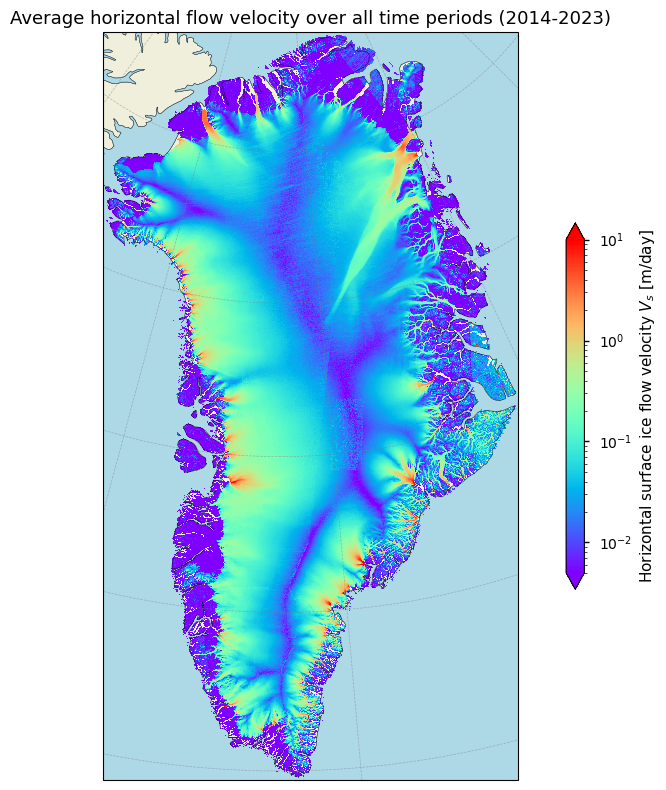

In [6]:
# Plot:
da = ds["land_ice_surface_velocity_magnitude"]
da.attrs = {
    "long_name": r"Horizontal surface ice flow velocity $V_{s}$",
    "units": "m/day",
}

plot_mean_map(
    da,
    norm=matplotlib.colors.LogNorm(),
)

*Figure 1. Magnitude of the average horizontal surface flow velocities over Greenland over the defined time period.*

The corresponding data are annually averaged values, derived from all year-round observations during the glaciological balance year of the GrIS (1 October to 30 September). The horizontal velocity data effectively highlight the low-flow zones in the interior and the increased velocities near the ice sheet‚Äôs margins and outlet glaciers. This pattern aligns with findings from other GrIS velocity maps in the literature (e.g. [[2](https://doi.org/10.1017/jog.2017.73), [3](https://nsidc.org/data/nsidc-0777/versions/1)]). The annually averaged nature meets the minimum requirement set by the Global Climate Observing System (GCOS) [[4](https://library.wmo.int/records/item/58111-the-2022-gcos-ecvs-requirements-gcos-245)], providing a comprehensive overview of ice flow velocities. However, there is no information given related to the time of the year during which valid pixels for the velocity calculation were acquired. Also the spatial resolution of 250 m meets the threshold value proposed by GCOS. In other words, both the spatial and temporal resolution meet the minimum requirement to ensure that data are useful for use in climatological, hydrological and glaciological studies and applications.

(section-2-2)=
#### 2.2 Average horizontal ice flow direction

We can also plot flow directions (i.e. the direction to which the ice flows measured clockwise from the north). For that, we calculate the circular mean:

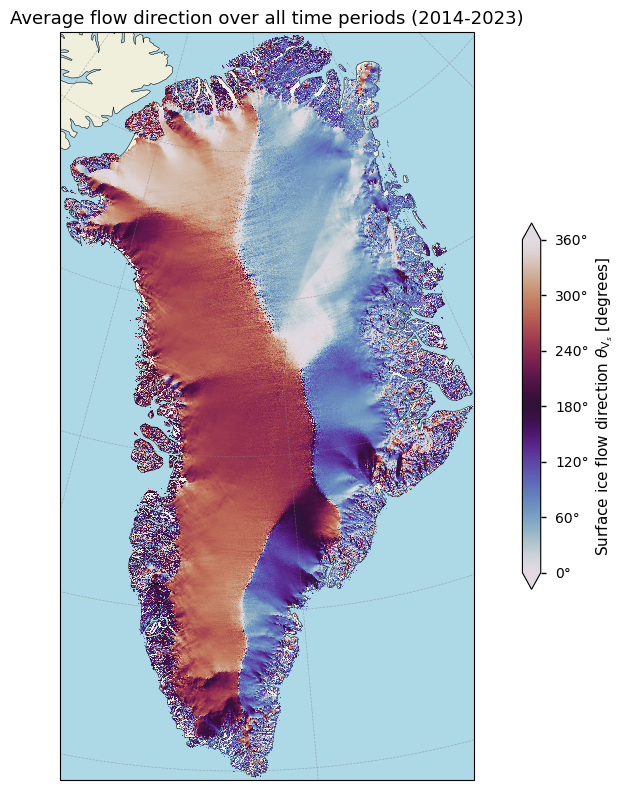

In [7]:
# Apply to flow direction
da = ds["land_ice_flow_direction"]
da.attrs = {
    "long_name": r"Surface ice flow direction $\theta_{\text{V}_s}$",
    "units": "degrees",
}

plot_mean_map(
    da,
    cmap="twilight",
    vmin=0,
    vmax=360,
)

*Figure 2. Average directon of the horizontal surface flow velocities over Greenland over the defined time period.*

The provided image displays the average ice flow direction for Greenland averaged over all available periods. The color scale indicates the direction of ice flow in degrees, measured clockwise from north (northwards = 0¬∞/360¬∞, eastwards = 90¬∞, southwards = 180¬∞, westwards = 270¬∞). Several ice divides are visible, of which the most prominent one is situated meriodionally over central Greenland where flow directions diverge, leading to different drainage basins. The predominant direction of the ice flow is consistent with the topographical characteristics of the ice sheet (i.e. ice flows perpendicular to the direction of the steepest surface slope). 

Let us now analyze the spatial and temporal resolution and coverage of the dataset. 

(section-3)=
### 3. Analysis of spatio-temporal resolution and extent of ice sheet velocities

(section-3-1)=
#### 3.1 Temporal extent of the ice sheet velocity dataset

We begin our analysis by examining the temporal extent of the dataset:

In [8]:
print(f"The temporal extent of the ice sheet velocity dataset for the GrIS is {np.shape(ds['period'])[0]} years.")

The temporal extent of the ice sheet velocity dataset for the GrIS is 9 years.


To determine whether the temporal extent of the ice sheet velocity dataset is sufficient to capture reliable temporal trends in horizontal surface velocities and to use these trends as indicators of climatic changes, we turn to the literature. The Intergovernmental Panel on Climate Change (IPCC) often uses 30 years as a standard period for climate normals and trend analysis to ensure that the analysis captures meaningful climatic changes rather than short-term (intra/interannual) fluctuations. We therefore consider these guidelines to be likewise applicative for ice flow velocities. 

When measured over a long period (> 30 years), significant trends in surface flow velocities can be considered a clear indicator of a disequilibrium of the ice sheet with the environment, for example due to climate change. Longer periods provide even more robust trend estimates and reduce the influence of short-term variability. However, the dataset (as of versions 1.3 to 1.5 with 9 years of data) is clearly not of sufficient temporal extent for this purpose.

(section-3-2)=
#### 3.2 Spatial coverage of the ice sheet velocity dataset

To have a more extended idea of the temporal and spatial coverage of the gridded dataset, we can plot the total amount of pixels that hold non-NaN velocity data for each year. Let us have this quantified:

In [9]:
# Apply the function to the velocity counts
filtered_data = ds["land_ice_surface_velocity_magnitude"].where(ds["land_ice_surface_velocity_magnitude"] != 0)
non_nan_counts = filtered_data.count(dim=["x", "y"])

non_nan_counts.attrs = {
    "long_name": "Valid measurement counts",
    "units": "counts",
}
# Print values
for i, err in enumerate(non_nan_counts):
    print(f"The total amount of pixels holding non-NaN values " 
          f"for the year {int(i)+int(period_start[:4])}-{int(i)+int(period_start[5:])} CE "
          f"is {int(non_nan_counts.values[i])} counts, which equals a surface area of {1e-12*250*250*int(non_nan_counts.values[i]):.5f} million km¬≤.")

The total amount of pixels holding non-NaN values for the year 2014-2015 CE is 33048867 counts, which equals a surface area of 2.06555 million km¬≤.
The total amount of pixels holding non-NaN values for the year 2015-2016 CE is 34139948 counts, which equals a surface area of 2.13375 million km¬≤.
The total amount of pixels holding non-NaN values for the year 2016-2017 CE is 34195665 counts, which equals a surface area of 2.13723 million km¬≤.
The total amount of pixels holding non-NaN values for the year 2017-2018 CE is 34146643 counts, which equals a surface area of 2.13417 million km¬≤.
The total amount of pixels holding non-NaN values for the year 2018-2019 CE is 34166241 counts, which equals a surface area of 2.13539 million km¬≤.
The total amount of pixels holding non-NaN values for the year 2019-2020 CE is 34181540 counts, which equals a surface area of 2.13635 million km¬≤.
The total amount of pixels holding non-NaN values for the year 2020-2021 CE is 34210311 counts, which equa

Given that the surface area of the entire continent of Greenland roughly equals 2.165 million km¬≤ (of which ca. 80% covered by ice), it is clear that almost the entire continent is covered by the product, including ice-free areas. Let us determine what percentage of the pixels hold a time series of data with a length that is equal to the magnitude of the `time` dimension of the dataset:

In [10]:
filtered_data = ds["land_ice_surface_velocity_magnitude"].where(ds["land_ice_surface_velocity_magnitude"] != 0)
non_nan_counts = filtered_data.count(dim=["period"])
non_nan_counts = non_nan_counts.where(non_nan_counts != 0, np.nan)
equal_to_time = non_nan_counts == np.shape(ds['period'])[0]
larger_than_0 = non_nan_counts > 0
print(f"The number of pixels that have a time series of valid velocity data of {np.shape(ds['period'])[0]} years, which is the total number of years in the dataset, is {equal_to_time.values.sum()} pixels or {(100*(equal_to_time.values.sum())/larger_than_0.values.sum()):.2f}%.")

The number of pixels that have a time series of valid velocity data of 9 years, which is the total number of years in the dataset, is 32911734 pixels or 96.18%.


The amount of missing data can therefore be considered limited. 

Let us now check where the missing pixels are. In the plot below, pixels with a time series of valid data that are lower than the time dimension of the data are colored red, else they are colored green:

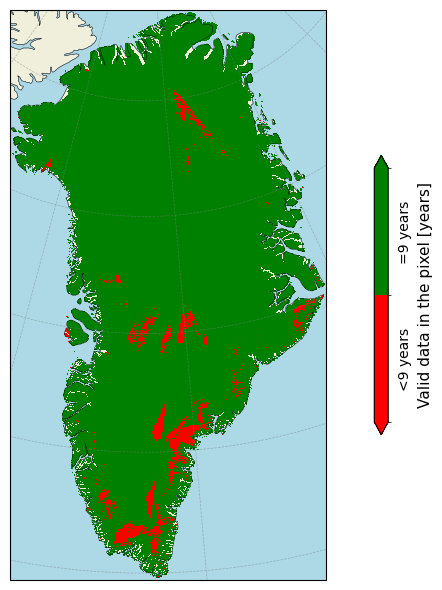

In [11]:
def plot_maps_single(da, suptitle=None, **kwargs):
    # Create subplots with Polar Stereographic projection
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.Stereographic(central_longitude=-45, central_latitude=90, true_scale_latitude=70)})
    
    # Plot the data 
    subset_da = da
    im = subset_da.plot.imshow(ax=ax, add_colorbar=False, **kwargs)
    
    # Set extent and plot features
    ax.set_extent([da.coords['x'].values.min(), da.coords['x'].values.max(), da.coords['y'].values.min(), da.coords['y'].values.max()], ccrs.Stereographic(central_longitude=-45, central_latitude=90, true_scale_latitude=70))
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.OCEAN, color='lightblue')
    ax.coastlines()
    ax.set_title(None)
    ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    
    # Add colorbar
    cb = fig.colorbar(im, ax=ax, extend='both', shrink=0.49, label=f"{da.attrs['long_name']} [{da.attrs['units']}]")
    cb.set_ticks([0.35, 0.85])  # Set the ticks at the midpoints of the ranges
    cb.set_ticklabels([f'<{np.shape(ds["period"])[0]} years', f'={np.shape(ds["period"])[0]} years'])  # Set the tick labels
    cb.ax.yaxis.set_tick_params(rotation=90)
    cb.ax.yaxis.set_tick_params(length=0)

    plt.tight_layout()
    plt.show()

# Apply the function to the velocity data
da = equal_to_time.where(~np.isnan(ds["land_ice_surface_velocity_magnitude"].sel(period='2020-2021')))
da.attrs = {
    "long_name": r"Valid data in the pixel",
    "units": "years",
}

# Define bounds and colormap
bounds = [0, 0.5, 1]  # Green (0), Red (1)
cmap = matplotlib.colors.ListedColormap(['red', 'green'])
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

_ = plot_maps_single(
    da,
    cmap=cmap,
    norm=norm,
)

*Figure 3. Presence of missing data of the horizontal surface flow velocities over Greenland over the defined time period.*

The dataset thus offers GrIS velocity data at regular and consistently spaced temporal intervals (e.g. annually averaged data), and there are (almost) no spatial/temporal gaps in the data that could affect a (local or ice sheet-wide) trend analysis. However, the total number of consecutive years in the dataset is too low to perform a reliable temporal trend analysis. In other words, from the above analysis it becomes clear that the dataset exhibits a consistently complete temporal and spatial coverage, with practically no data gaps, which would allow for reliable quantifications of velocity means, variability and trends if the temporal extent would have been sufficient. Moreover, an ice mask is not included and it is thus not possible to exclude non ice-covered pixels from the data. Pixels over ice-free terrain hold non-NaN data and have not been removed, implying that the data exhibits false low velocity measurements and noise over ice-free terrain.

(section-4)=
### 4. Trends of annually averaged horizontal surface ice flow velocities

(section-4-1)=
#### 4.1 Linear trends of horizontal ice flow velocities

Although the temporal extent is not sufficient to derive reliable values for the mean, variability and trends (as discussed above), we can still plot a time series of annually averaged ice sheet-wide velocity data to get an idea of their magnitudes and their change over time in the dataset. Let us print the average values over the entire ice sheet for each hydrological year:

In [12]:
da = ds["land_ice_surface_velocity_magnitude"]
da.attrs = {
    "long_name": "Horizontal ice flow velocity V",
    "units": ds[name].attrs["units"],
}
velocity_values = []
# Print values
for i, err in enumerate(da):
    print(f"The annually averaged ice sheet-wide horizontal surface ice flow velocity " 
          f"for the year {int(i)+int(period_start[:4])}-{int(i)+int(period_start[5:])} CE "
          f"is {float(np.abs(np.nanmean(da[i,:]))):.4f} m/day.")
    mean_velocity = np.abs(np.nanmean(da[i,:]))
    velocity_values.append(mean_velocity)

The annually averaged ice sheet-wide horizontal surface ice flow velocity for the year 2014-2015 CE is 0.1124 m/day.
The annually averaged ice sheet-wide horizontal surface ice flow velocity for the year 2015-2016 CE is 0.1113 m/day.
The annually averaged ice sheet-wide horizontal surface ice flow velocity for the year 2016-2017 CE is 0.1134 m/day.
The annually averaged ice sheet-wide horizontal surface ice flow velocity for the year 2017-2018 CE is 0.1172 m/day.
The annually averaged ice sheet-wide horizontal surface ice flow velocity for the year 2018-2019 CE is 0.1164 m/day.
The annually averaged ice sheet-wide horizontal surface ice flow velocity for the year 2019-2020 CE is 0.1154 m/day.
The annually averaged ice sheet-wide horizontal surface ice flow velocity for the year 2020-2021 CE is 0.1131 m/day.
The annually averaged ice sheet-wide horizontal surface ice flow velocity for the year 2021-2022 CE is 0.1132 m/day.
The annually averaged ice sheet-wide horizontal surface ice flow

Let us now have this plotted on a graph:

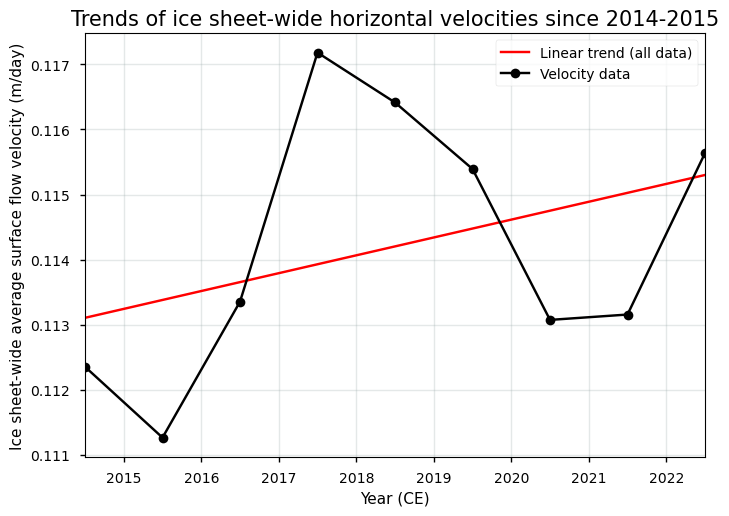

In [23]:
# Extract time and velocity data
periods = [f"{int(period_start[:4]) + i}-{int(period_start[5:]) + i}" for i in range(len(velocity_values))]
# Convert period strings to numerical values (midpoint of each period)
def period_to_year(period):
    start_year, end_year = map(int, period.split('-'))
    return (start_year + end_year) / 2
time = np.array([period_to_year(period) for period in periods])
veloc_data = np.array(velocity_values)
# Calculate linear trend
coeffs = np.polyfit(time, veloc_data, 1)  # 1 indicates a linear fit (degree 1 polynomial)
trend = np.polyval(coeffs, time)  # Evaluate the polynomial at the given time points
# Plot the data
fig, ax = plt.subplots()
ax.plot(time,trend,'r',label='Linear trend (all data)')
ax.plot(time,veloc_data,'k', marker='o',label='Velocity data')
ax.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax.set_xlim(np.min(time),np.max(time))
ax.set_xlabel("Year (CE)")
ax.set_ylabel("Ice sheet-wide average surface flow velocity (m/day)")
ax.legend()
ax.set_title("Trends of ice sheet-wide horizontal velocities since "+ period_start.replace("_","-"),fontsize=15);plt.show()

*Figure 4. Linear trend of the ice sheet-wide average horizontal surface flow velocities over Greenland over the defined time period.*

We can quantify the linear trend as follows:

In [14]:
# Quantify the linear trend (coeffs[0] is the slope, coeffs[1] is the intercept)
print(f"The linear trend of the ice sheet-wide horizontal surface ice flow velocity between {period_start.replace('_', '-')} and {period_stop.replace('_', '-')} is {coeffs[0]:.4f} m day‚Åª¬π yr‚Åª¬π.")

The linear trend of the ice sheet-wide horizontal surface ice flow velocity between 2014-2015 and 2022-2023 is 0.0003 m day‚Åª¬π yr‚Åª¬π.


The provided plot shows the trend of ice sheet-wide horizontal surface ice flow velocities since the period 2014-2015. The linear trend shows an increase in the ice sheet-wide horizontal surface ice flow velocity over time. This means that the ice flow has generally been speeding up over this period. This generally agrees with what can be expected (initially) from a warming climate, although the impact of climate change on the GrIS dynamic patterns is complex in both space and time. The outlet glaciers of the GrIS are currently retreating, calving more icebergs, and also flowing faster. Many major outlet glaciers in Greenland (e.g. Jakobshavn Isbr√¶, Helheim, and Kangerlussuaq) experienced substantial speed-ups during the last several decades. This acceleration was mainly linked to oceanic and atmospheric warming, which led to increased basal sliding and reduced backstress (buttressing), hereby enhancing flow speed (e.g. [[5](https://doi.org/10.5194/tc-6-923-2012), [6](https://doi.org/10.1038/s41586-022-05301-z), [7](https://doi.org/10.1038/s43247-020-0001-2)]). However, studies indicate that this ongoing acceleration cannot simply be extrapolated throughout the 21st century and beyond. In the future, the ice sheet's thinning is expected to slow down the ice due to the inverse relationship between ice thickness and ice velocity, as expected from physical theory and confirmed by model experiments (e.g. [[8](https://doi.org/10.5194/tc-9-1039-2015), [12](https://doi.org/10.1017/jog.2022.9)]). 

However, it must be said that the temporal extent of the velocity data is relatively short. Longer-term observations (> 30 years) are necessary to identify persistent trends and separate short-term variability from long-term changes. Moreover, the trend in ice sheet-wide velocity data for Greenland may be influenced by the inclusion of unrealistic velocity data over ice-free terrain, whereas certain zones, such as the glacier margins, may be subject to lower data quality as well [[9](https://doi.org/10.1016/j.rse.2017.08.038)]. Therefore, further investigation and long-term monitoring of velocities over ice-covered areas are essential to accurately and reliably assess and interpret trends of ice flow velocities and their implications for future ice sheet behavior and sea-level rise.

(section-4-2)=
#### 4.2 Implications for deriving multi-year trends of surface flow velocities and associated patterns of solid ice discharge

Reliable and long-term trends in ice sheet flow velocities are essential for understanding the complex dynamics of ice sheets and the impact of climate change. One of such processes for which ice flow velocities are important is the quantification of solid ice discharge.

Solid ice discharge is the transport of solid ice across the grounding line of an ice sheet. This process represents the loss of grounded ice from the ice sheet to the ocean due to ice flow. The grounding line is the boundary between the grounded ice sheet, where ice rests on bedrock, and the floating ice, which is buoyant. As ice flows from the grounded portion of the ice sheet into the ocean, it contributes to sea-level rise. Solid ice discharge $D$ therefore is a critical component of the total mass balance of an ice sheet [[10](https://essd.copernicus.org/articles/12/1367/2020/)]:

$\Delta M = SMB - D$

where:
- $\Delta M$ is the total mass balance or the total ice mass loss or gain [Gt yr$^{-1}$],
- $SMB$ is surface mass balance (often also supplemented by the basal and internal mass balance) [Gt yr$^{-1}$],
- $D$ is the solid ice discharge (zero for land-terminating glaciers/ice sheets) [Gt yr$^{-1}$].

The solid discharge $D$ can be further expressed as a mass flux as follows:

$D = \rho_i \cdot \overline{V_P} \cdot A = \rho_i \cdot \overline{V_P} \cdot H \cdot w 
$

where
- $\rho_i$ is the ice density [kg m$^{-3}$]
- $\overline{V_P}$ the gate-perpendicular vertically averaged horizontal ice flow velocity at the grounding line [m yr$^{-1}$]

  ‚âà $\overline{V}\cdot cos(\theta)$ with $\theta$ the difference between ice flow and gate-perpendicular azimuths and where $\overline{V}$ approximately equals the surface velocity $V_s$
- $H$ the ice thickness at the grounding line [m]
- $A$ the considered cross-sectional area [m]
- $w$ the width of the cross section across the groundling line [m].

Ice flow velocities are thus an important component to assess the solid ice discharge and its trends over time. The dataset provided for monitoring GriS surface flow velocity patterns on the CDS is a relatively mature dataset that can serve as input for solid ice discharge calculations, as it has a suitable spatial resolution for capturing detailed flow patterns, particularly near ice margins and outlet glaciers. The spatial coverage is furthermore comprehensive, encompassing the entire ice sheet, including peripheral glaciers and ice caps, with almost no gaps present. The dataset's completeness thus appears high, with minimal missing values. 

However, the temporal coverage only extends from 2014-2015 onwards, which is too short to perform a reliable long-term trend analysis. The dataset's short temporal extent therefore poses a limitation to deduce reliable long-term trends of horizontal surface flow velocities and solid ice discharge. Furthermore, to precisely quantify the solid ice discharge, also other additional and external datasets of other variables are needed, of which the most important ones are the position of the grounding line and the ice thickness at those locations [[10](https://doi.org/10.5194/essd-12-1367-2020)]. Moreover, the dataset provides horizontal surface velocities, while solid ice discharge calculations require vertically averaged horizontal velocities. However, because basal sliding is generally the dominant process that defines the ice velocity at the grounding line, velocities generally do not vary significantly with depth at these locations [[10](https://doi.org/10.5194/essd-12-1367-2020)]. Next, with only yearly maps, this product can only calculate interannual changes in ice discharge, which may not be sufficient for certain users. This may be particularly true for the GrIS, where many outlet glaciers exhibit significantly distinct seasonal variations in ice velocity. The lack of information related to the time of the year of the valid data acquisitions, as well as higher standard deviations near the margins and a missing ice mask that can be used to distinguish between ice-covered and non ice-covered grid cells, further complicate the use of the data. Hence, for comprehensive glaciological studies and solid ice discharge modeling, supplementary datasets with a longer temporal extent (preferably > 30 years) and higher temporal resolution (subannual) should be considered to fully capture the changing patterns of ice flow dynamics. 

(section-5)=
### 5. Short summary and take-home messages

When measured over long periods and extensive geographical scales, trends in GrIS ice sheet flow velocities and solid ice discharge are clear indicators of global climate change [[9](https://doi.org/10.1016/j.rse.2017.08.038), [10](https://doi.org/10.5194/essd-12-1367-2020)]. To be able to derive such trends of ice sheet velocities and for climate change analysis/monitoring to become reliable and possible, the velocity dataset should at least exhibit a comprehensive spatial coverage (i.e. ice sheet-wide), a long and continuous temporal coverage (> 30 years), quantified and transparent pixel-by-pixel uncertainty estimates that meet international proposed thresholds [[4](https://library.wmo.int/records/item/58111-the-2022-gcos-ecvs-requirements-gcos-245)], a validation effort or a comparison to theoretical models, and an adequate spatio-temporal resolution (cfr. the "Maturity Matrix" [[11](https://doi.org/10.1175/BAMS-D-21-0109.1)]).

The [ice sheet velocity dataset on the CDS](https://cds.climate.copernicus.eu/datasets/satellite-greenland-ice-sheet-velocity?tab=overview) is found to exhibit a consistent suitable spatial (250 m) and temporal (annual) resolution, but a less extensive temporal coverage (< 30 years), to conduct a meaningful analysis of linear (and quadratic) trends in ice sheet surface velocities and solid ice discharge. Nevertheless, the spatial and temporal resolution/extent of the data align with international standards such as those proposed by GCOS [[4](https://library.wmo.int/records/item/58111-the-2022-gcos-ecvs-requirements-gcos-245)] and data gaps are practically non-existent in this dataset. An even finer temporal resolution would, however, be beneficial to better capture subannual variations in flow speeds and solid ice discharge estimates. Validation efforts also show encouraging results, as shown in the [PQAR](https://confluence.ecmwf.int/pages/viewpage.action?pageId=355348656). The resulting trends from the C3S dataset show a general speedup of the GrIS over the last few years. 

Taking all of the above into account, the SAR offset tracking-based GrIS velocity dataset is generally considered to be relatively well-suited for use in the context of visualizing the spatial patterns of ice flow and for solid ice discharge quantifications in terms of its spatial/temporal resolution, spatial coverage and data completeness. However, the GrIS velocity data are at this stage found to be less suitable to derive corresponding long-term trends (climate change signals) and inter/intra-annual variability of the flow velocities, due to the limited temporal extent (only a few years) and resolution (not finer than annual). Moreover, noise over ice-free terrain, relatively high absolute error values around the margins and the lack of information regarding the time of valid data acquisitions impact the overall data quality. Users should thus acknowledge the above-mentioned limitations for this dataset and its impact on the derivation of (long-term) surface ice flow velocity trends from the C3S data. If one wants to proceed to derive solid ice discharge, additional data (i.e. the grounding line position, the ice thickness at those positions, and a conversion factor to derive vertically averaged horizontal velocities) are furthermore required. 

## ‚ÑπÔ∏è If you want to know more

### Key resources

- "[Ice sheet velocity for Antarctica and Greenland derived from satellite observations](https://cds.climate.copernicus.eu/datasets/satellite-greenland-ice-sheet-velocity?tab=overview)" on the CDS
- [Documentation on the CDS](https://cds.climate.copernicus.eu/datasets/satellite-greenland-ice-sheet-velocity?tab=documentation) and the [ECMWF Confluence Wiki](https://confluence.ecmwf.int/pages/viewpage.action?pageId=355348656) (Copernicus Knowledge Base).
- [Copernicus climate change indicators: ice sheets](https://climate.copernicus.eu/climate-indicators/ice-sheets)
- [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control` prepared by [B-Open](https://www.bopen.eu).

### References

- [[1](https://doi.org/10.3390/rs70709371)] Nagler, T., Rott, H., Hetzenecker, M., Wuite, J. and Potin, P. (2015). The Sentinel-1 Mission: New Opportunities for Ice Sheet Observations. Remote Sensing. 7(7):9371-9389. https://doi.org/10.3390/rs70709371

- [[2](https://doi.org/10.1017/jog.2017.73)] Joughin, I., Smith, B. E., and Howat, I. M. (2018). A complete map of Greenland ice velocity derived from satellite data collected over 20 years, J. Glaciol., 64, 1‚Äì11, https://doi.org/10.1017/jog.2017.73

- [[3](https://nsidc.org/data/nsidc-0777/versions/1)] Howat, I., Chudley, T., and Noh, M. (2022). MEaSUREs Greenland Ice Velocity: Selected Glacier Site Single-Pair Velocity Maps from Optical Images, https://doi.org/10.5067/b28fm2qvvywy

- [[4](https://library.wmo.int/records/item/58111-the-2022-gcos-ecvs-requirements-gcos-245)] GCOS (Global Climate Observing System) (2022). The 2022 GCOS ECVs Requirements (GCOS-245). World Meteorological Organization: Geneva, Switzerland. doi: https://library.wmo.int/idurl/4/58111

- [[5](https://doi.org/10.5194/tc-6-923-2012)] Bevan, S. L., Luckman, A. J., and Murray, T. (2012). Glacier dynamics over the last quarter of a century at Helheim, Kangerdlugssuaq and 14 other major Greenland outlet glaciers, The Cryosphere, 6, 923‚Äì937, https://doi.org/10.5194/tc-6-923-2012

- [[6](https://doi.org/10.1038/s41586-022-05301-z)] Khan, S. A., Choi, Y., Morlighem, M., Rignot, E., Helm, V., Humbert, A., Mouginot, J., Millan, R., Kj√¶r, K. H., and Bj√∏rk, A. A. (2022). Extensive inland thinning and speed-up of Northeast Greenland Ice Stream. Nature, 611, 727‚Äì732, https://doi.org/10.1038/s41586-022-05301-z

- [[7](https://doi.org/10.1038/s43247-020-0001-2)] King, M. D., Howat, I. M., Candela, S. G., Noh, M. J., Jeong, S., No√´l, B. P. Y., van den Broeke, M. R., Wouters, B., and Negrete, A. (2020). Dynamic ice loss from the Greenland Ice Sheet driven by sustained glacier retreat. Communications Earth & Environment, 1, Article 1. https://doi.org/10.1038/s43247-020-0001-2

- [[8](https://doi.org/10.5194/tc-9-1039-2015)] F√ºrst, J. J., Goelzer, H., and Huybrechts, P. (2015). Ice-dynamic projections of the Greenland ice sheet in response to atmospheric and oceanic warming, The Cryosphere, 9, 1039‚Äì1062, https://doi.org/10.5194/tc-9-1039-2015

- [[9](https://doi.org/10.1016/j.rse.2017.08.038)] Paul, F., Bolch, T., Briggs, K., K√§√§b, A., McMillan, M., McNabb, R., Nagler, T., Nuth, C., Rastner, P., Strozzi, T., and Wuite, J. (2017). Error sources and guidelines for quality assessment of glacier area, elevation change, and velocity products derived from satellite data in the Glaciers_cci project, Remote Sensing of Environment, 203, 256-275. https://doi.org/10.1016/j.rse.2017.08.038

- [[10](https://doi.org/10.5194/essd-12-1367-2020)] Mankoff, K.D., Solgaard, A., Colgan, W., Ahlstr√∏m, A.P., Khan, S.A., and Fausto, R.S. (2020). Greenland Ice Sheet solid ice discharge from 1986 through March 2020, Earth System Science Data, 12, 1367‚Äì1383. https://doi.org/10.5194/essd-12-1367-2020

- [[11](https://doi.org/10.1175/BAMS-D-21-0109.1)] Yang, C. X., Cagnazzo, C., Artale, V., Nardelli, B. B., Buontempo, C., Busatto, J., Caporaso, L., Cesarini, C., Cionni, I., Coll, J., Crezee, B., Cristofanelli, P., de Toma, V., Essa, Y. H., Eyring, V., Fierli, F., Grant, L., Hassler, B., Hirschi, M., Huybrechts, P., Le Merle, E., Leonelli, F. E., Lin, X., Madonna, F., Mason, E., Massonnet, F., Marcos, M., Marullo, S., Muller, B., Obregon, A., Organelli, E., Palacz, A., Pascual, A., Pisano, A., Putero, D., Rana, A., Sanchez-Roman, A., Seneviratne, S. I., Serva, F., Storto, A., Thiery, W., Throne, P., Van Tricht, L., Verhaegen, Y., Volpe, G., and Santoleri, R. (2022). Independent Quality Assessment of Essential Climate Variables: Lessons Learned from the Copernicus Climate Change Service, B. Am. Meteorol. Soc., 103, E2032‚ÄìE2049, https://doi.org/10.1175/Bams-D-21-0109.1

- [[12](https://doi.org/10.1017/jog.2022.9)] Greve, R. and C. Chambers (2022). Mass loss of the Greenland ice sheet until the year 3000 under a sustained late-21st-century climate. Journal of Glaciology 68 (269), 618-624, https://doi.org/10.1017/jog.2022.9‚ÄÇ